<center>
<h2> Optimization of a stopping strategy </h2>
<h2> By : BULAHIA Youssef </h2>

<center>
<h5> Part I - Basic functions and Monte-Carlo </h5>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize_scalar
import math

In [3]:
def simul_s(S0, sigma, N, dt, nb_traj, seed = 42):
    np.random.seed(seed)
    epsilons = np.random.normal(size=(nb_traj, N))
    a = np.exp((-0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * epsilons)
    trajectories = np.ones((nb_traj, N+1)) * S0
    for i in range(1,N+1) :
        trajectories[:, i]= trajectories[:, i-1] * a[:, i-1]
    return trajectories

In [4]:
import pandas as pd

def simul_s2(S0, sigma, N, dt, nb_traj, seed = 42):
    np.random.seed(seed)
    epsilons = np.random.normal(size=(nb_traj, N))
    a = ((-0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * epsilons).cumsum(axis=1)
    trajectories = np.ones((nb_traj, N+1)) * S0
    trajectories[:,1:] = np.exp(a) * S0
    
    return trajectories

In [5]:
def s_to_a(trajectories) :
    return trajectories.cumsum(axis = 1) / np.ones(trajectories.shape).cumsum(axis = 1)

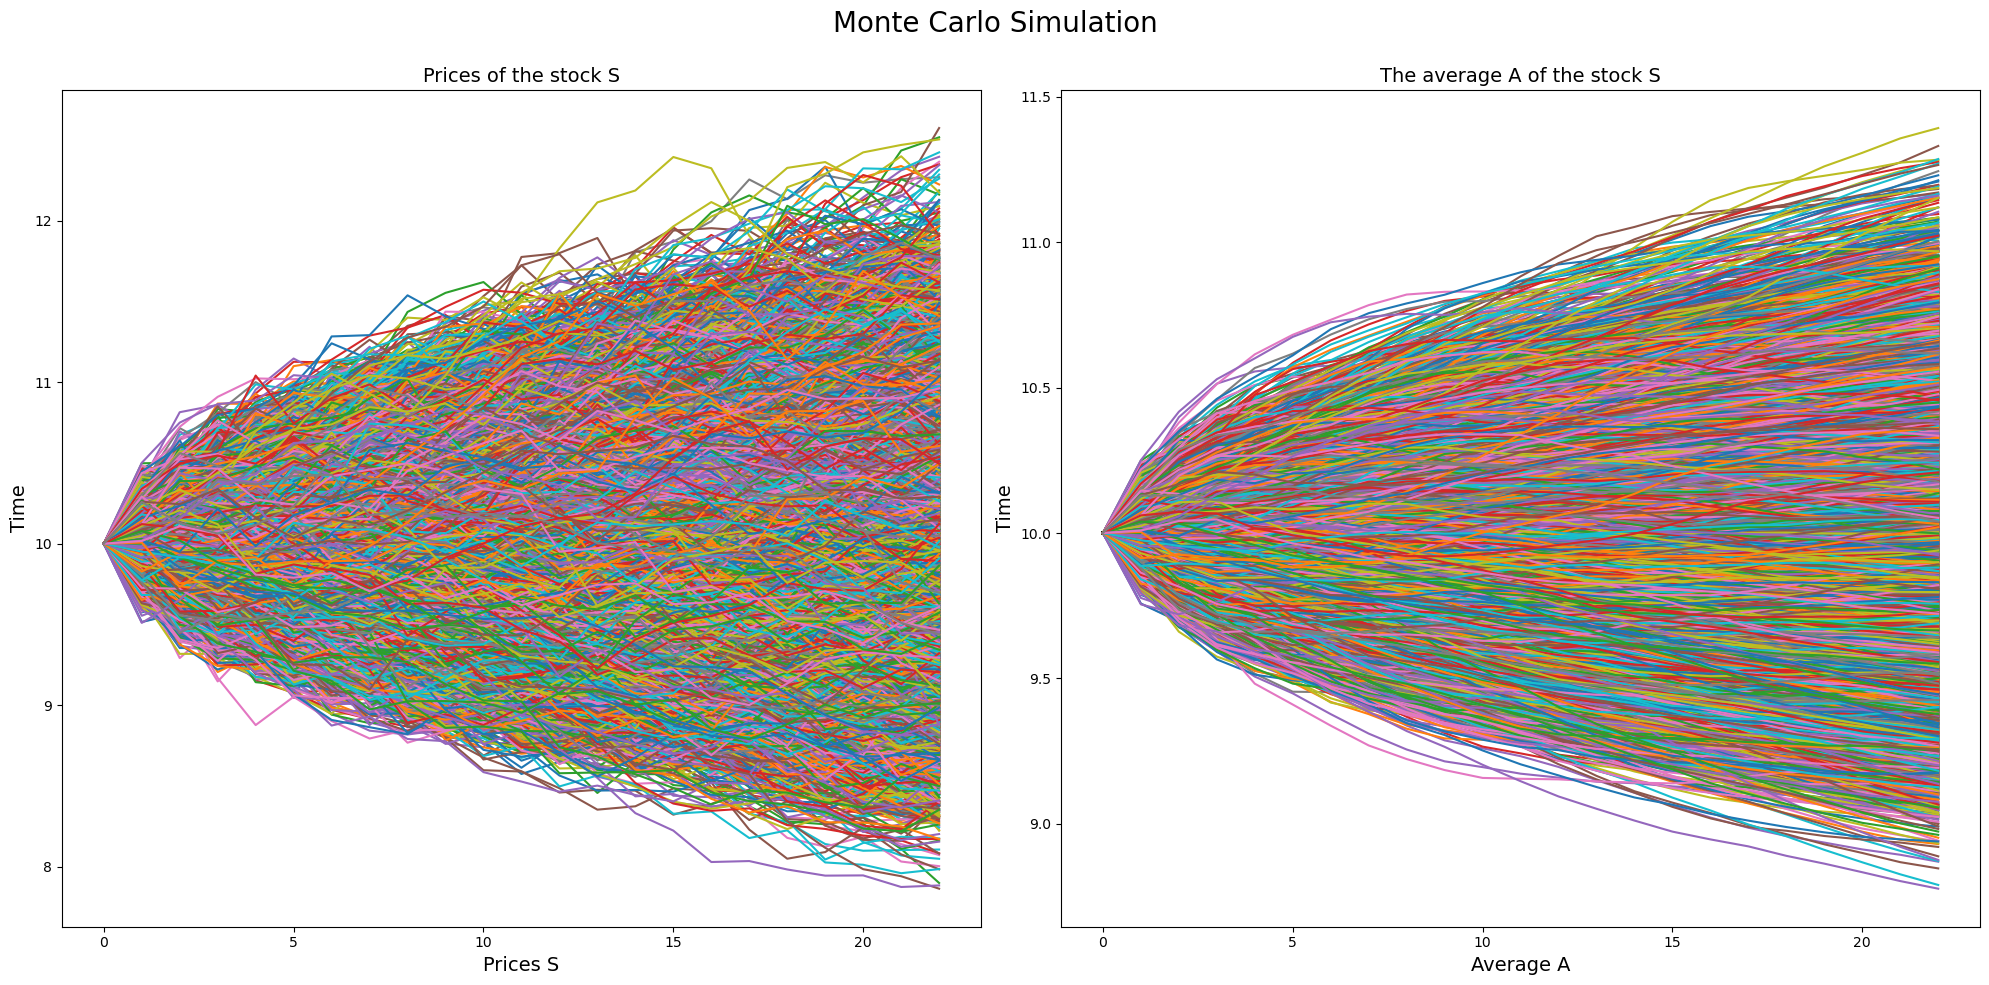

In [6]:
S0 = 10
sigma = 0.2
dt = 1/252
N = 22
nb_traj = 2**15

x = simul_s2(S0, sigma, N, dt, nb_traj)
y = s_to_a(x)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Monte Carlo Simulation', fontsize=20)

axs[0].plot(x.T)
axs[0].set_title('Prices of the stock S', fontsize=14)
axs[0].set_xlabel('Prices S', fontsize=14)
axs[0].set_ylabel('Time', fontsize=14)

axs[1].plot(y.T)
axs[1].set_title('The average A of the stock S', fontsize=14)
axs[1].set_xlabel('Average A', fontsize=14)
axs[1].set_ylabel('Time', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [7]:
def montecarlo(trajectories) :
    value = s_to_a(trajectories)[:,-1] / trajectories[:,-1]
    mean = np.mean(value)
    return mean, mean - 1.96 * np.std(value)/np.sqrt(len(trajectories)), mean + 1.96 * np.std(value)/np.sqrt(len(trajectories))

In [8]:
trajectories = simul_s(S0, sigma, N, dt, nb_traj)
montecarlo(trajectories)

(1.0016962661837403, 1.0013309556401597, 1.0020615767273209)

In [9]:
# Math question

E = (np.exp(sigma ** 2 * dt * np.arange(N + 1)) / (N+1)).sum()
E

1.0017481122115628

<center>
<h5> Part II - Strategy and Otimization </h5>

In [10]:
def strat_ratio(a, trajectories):
    A = s_to_a(trajectories)
    st_a = np.where(((A-a*trajectories)>=0).sum(axis=0)==1)[0]
    if len(st_a) == 0 :
        st_a = math.inf
    stopping_time_a = min(np.min(st_a), trajectories.shape[1]-1)
    return (A[:,stopping_time_a]/trajectories[:,stopping_time_a]).mean()

In [11]:
trajectories = simul_s(S0, sigma, N, dt, nb_traj)
strat_ratio(2, trajectories)

1.0016962661837403

In [12]:
objective_function = lambda a: -strat_ratio(a, trajectories)

result = minimize_scalar(objective_function, bounds=(1, 5000))

optimal_a = result.x

print("Optimal value of 'a':", optimal_a)
print("Maximum value of strat_ratio:", -result.fun)

Optimal value of 'a': 4999.999850263358
Maximum value of strat_ratio: 1.0016962661837403
